# Spotify Hit Songs

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier

## Data Preprocessing 

In [3]:
with open(r"./data/spotify_hit_songs.csv", 'r', encoding="utf8") as f:
    df_original = pd.read_csv(f)

## Understanding the Data

In [4]:
# Print information about null values in each column
print("Null values per column:")
print(df_original.isnull().sum())

# Print information about duplicates
subset_columns = ['track', 'artist', 'uri']
print("\nCount of duplicates based on track, artist and uri:")
print(df_original[df_original.duplicated(subset=subset_columns)].shape[0])

Null values per column:
track               0
artist              0
uri                 0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
dtype: int64

Count of duplicates based on track, artist and uri:
422


### Removing Duplicates
Since we found out we have 422 duplicates in our dataset, we want to remove these before performing any calculations on the dataset.

In [5]:
# Remove duplicates based on the specified columns
df = df_original.drop_duplicates(subset=subset_columns, keep='first')

print("Number of rows before removing duplicates:", len(df_original))
print("Number of rows after removing duplicates:", len(df))

# Print information of duplicates again to confirm removal
print("\nCount of duplicates based on track, artist and uri:")
print(df[df.duplicated(subset=subset_columns)].shape[0])

Number of rows before removing duplicates: 41106
Number of rows after removing duplicates: 40684

Count of duplicates based on track, artist and uri:
0


## PCA for Finding Relevant Attributes

In [6]:
attributes = ['danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence']

df_attributes = df[attributes]

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(df_attributes)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(standardized_data)

# Get the loadings of PC1 and PC2
loadings = pca.components_[:2, :]

# Get the attribute names
attribute_names = df_attributes.columns

# Sort attributes based on loadings
pc1_sorted_attributes = [attribute_names[i] for i in (-loadings[0]).argsort()]
pc2_sorted_attributes = [attribute_names[i] for i in (-loadings[1]).argsort()]

# Create list of attributes with the most variation
selected_attributes = [pc1_sorted_attributes[0], pc2_sorted_attributes[0], pc1_sorted_attributes[1], pc2_sorted_attributes[1]]

# Print the first attribute of PC1 and PC2
print("Attribute 1 primarily represented by PC1:", pc1_sorted_attributes[0])
print("Attribute 1 primarily represented by PC2:", pc2_sorted_attributes[0])
print("Attribute 2 primarily represented by PC1:", pc1_sorted_attributes[1])
print("Attribute 2 primarily represented by PC2:", pc2_sorted_attributes[1])

Attribute 1 primarily represented by PC1: acousticness
Attribute 1 primarily represented by PC2: liveness
Attribute 2 primarily represented by PC1: instrumentalness
Attribute 2 primarily represented by PC2: energy


In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=np.random.randint(0, 100))

X_train = df_train[selected_attributes]
y_train = df_train['target'].ravel()

X_test = df_test[selected_attributes]
y_test = df_test['target'].ravel()

cv_values = range(2, 11)

X_full = np.concatenate((X_train, X_test))
y_full = np.concatenate((y_train, y_test))

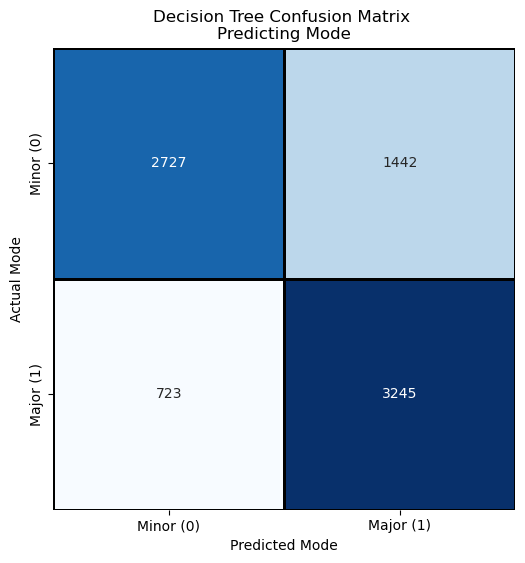

Decision Tree Accuracy: 73.39314243578714
Decision Tree Cross-Validation Score: 73.19586327020957


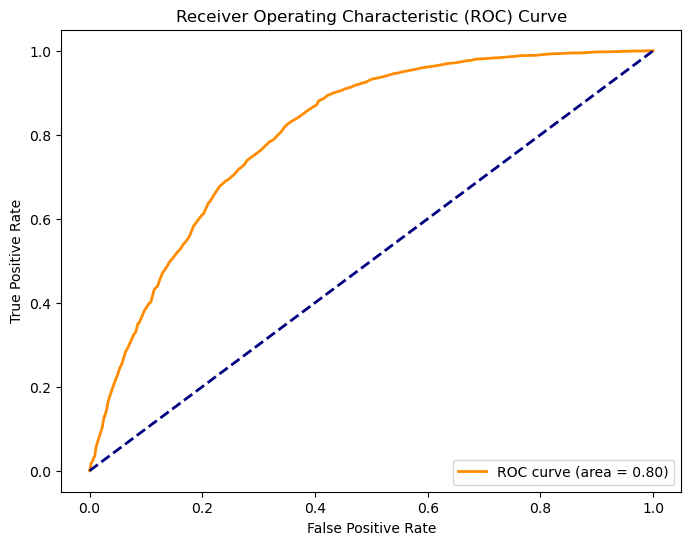

In [8]:
from sklearn.metrics import roc_curve, auc

# Train the Decision Tree Classifier
dtc = DecisionTreeClassifier(criterion='gini', min_samples_split=450)
dtc.fit(X_train, y_train)
dtc_y_pred = dtc.predict(X_test)

# Plot the confusion matrix
dtc_conf_matrix = confusion_matrix(y_test, dtc_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(dtc_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Minor (0)', 'Major (1)'], yticklabels=['Minor (0)', 'Major (1)'],
            linewidths=1, linecolor='black', square=True)
plt.title("Decision Tree Confusion Matrix \nPredicting Mode")
plt.xlabel("Predicted Mode")
plt.ylabel("Actual Mode")
plt.show()

# Evaluate accuracy score and cross-validation score
dtc_cv_score = cross_val_score(dtc, X_full, y_full, cv=5, scoring='accuracy').mean()
print(f"Decision Tree Accuracy: {dtc.score(X_test, y_test)*100}")
print(f"Decision Tree Cross-Validation Score: {dtc_cv_score*100}")

# Predict probabilities instead of classes for ROC curve
dtc_y_probs = dtc.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, dtc_y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

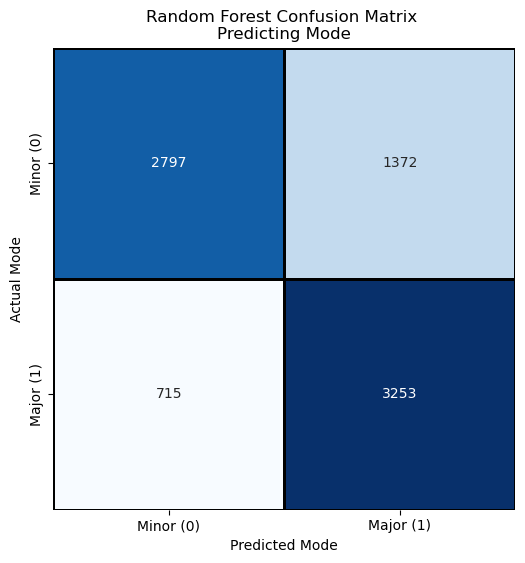

Random Forest Accuracy: 74.35172668059481
Decision Tree Cross-Validation Score: 74.0094463313785


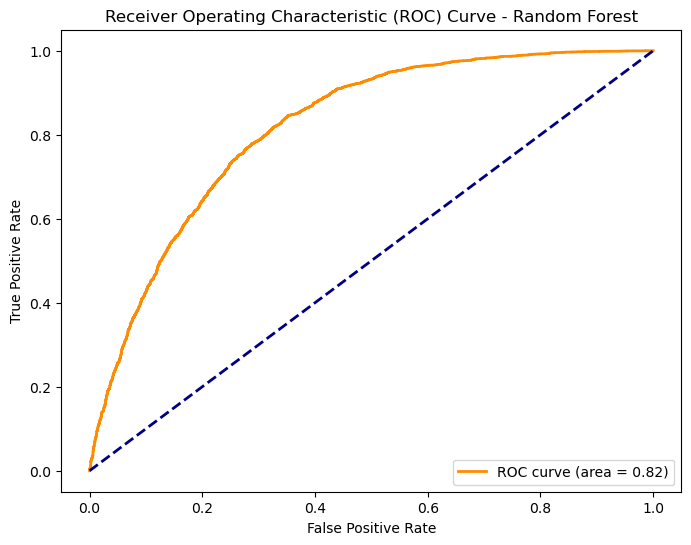

In [9]:
# Create and fit the Random Forest model
rf = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=450)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# Plot the confusion matrix
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Minor (0)', 'Major (1)'], yticklabels=['Minor (0)', 'Major (1)'],
            linewidths=1, linecolor='black', square=True)
plt.title("Random Forest Confusion Matrix \nPredicting Mode")
plt.xlabel("Predicted Mode")
plt.ylabel("Actual Mode")
plt.show()

# Evaluate accuracy
rf_cv_score = cross_val_score(rf, X_full, y_full, cv=5, scoring='accuracy').mean()
print(f"Random Forest Accuracy: {rf.score(X_test, y_test)*100}")
print(f"Decision Tree Cross-Validation Score: {rf_cv_score*100}")

# Predict probabilities instead of classes for ROC curve
rf_y_probs = rf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_y_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

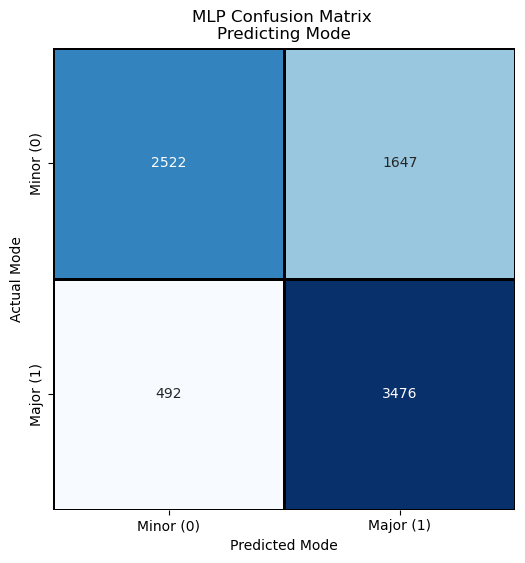

MLP Accuracy: 73.71%


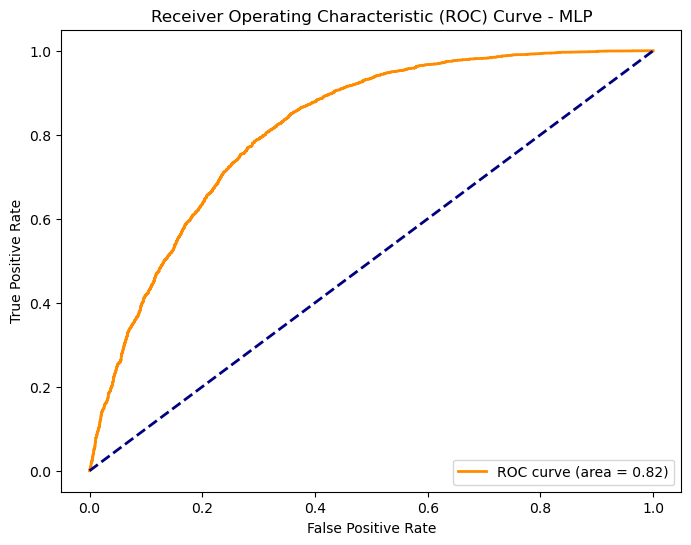

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create and fit the MLP (Multi-Layer Perceptron) model
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# Predict on the test set
mlp_y_pred = mlp.predict(X_test)

# Plot the confusion matrix
mlp_conf_matrix = confusion_matrix(y_test, mlp_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(mlp_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Minor (0)', 'Major (1)'], yticklabels=['Minor (0)', 'Major (1)'],
            linewidths=1, linecolor='black', square=True)
plt.title("MLP Confusion Matrix \nPredicting Mode")
plt.xlabel("Predicted Mode")
plt.ylabel("Actual Mode")
plt.show()

# Evaluate accuracy
mlp_accuracy = accuracy_score(y_test, mlp_y_pred)
print(f"MLP Accuracy: {mlp_accuracy * 100:.2f}%")

# Use predict_proba to get predicted probabilities
mlp_y_probs = mlp.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_y_probs)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_mlp))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - MLP')
plt.legend(loc='lower right')
plt.show()

In [11]:
# Count the occurrences of hits and flops
hits_count = df['target'].value_counts().get(1, 0)
flops_count = df['target'].value_counts().get(0, 0)

# Print the counts
print(f"Hits: {hits_count}")
print(f"Flops: {flops_count}")


Hits: 20131
Flops: 20553


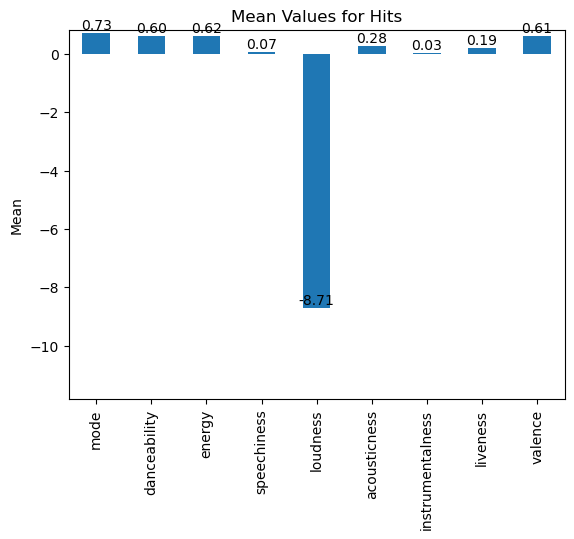

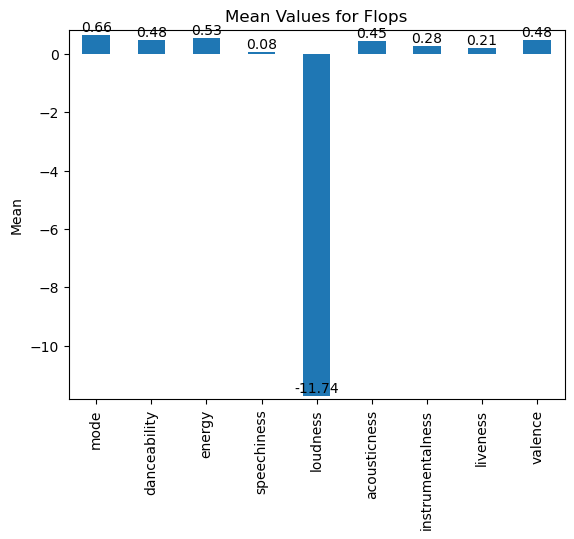

In [25]:
import matplotlib.pyplot as plt

selected_columns = ['mode', 'danceability', 'energy', 'speechiness', 'loudness',
                    'acousticness', 'instrumentalness', 'liveness', 'valence']

# Filter DataFrame for hits and flops
hits_df = df[df['target'] == 1]
flops_df = df[df['target'] == 0]

# Plot hits
hits_means = hits_df[selected_columns].mean()
hits_means.plot(kind='bar')
plt.title('Mean Values for Hits')
plt.ylabel('Mean')

# Annotate bars with numerical values
for i, value in enumerate(hits_means):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

# Set y-axis limits to cover both positive and negative values
plt.ylim(min(hits_means.min(), flops_df[selected_columns].mean().min()) - 0.1,
         max(hits_means.max(), flops_df[selected_columns].mean().max()) + 0.1)
plt.show()

# Plot flops
flops_means = flops_df[selected_columns].mean()
flops_means.plot(kind='bar')
plt.title('Mean Values for Flops')
plt.ylabel('Mean')

# Annotate bars with numerical values
for i, value in enumerate(flops_means):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

# Set y-axis limits to cover both positive and negative values
plt.ylim(min(hits_means.min(), flops_means.min()) - 0.1,
         max(hits_means.max(), flops_means.max()) + 0.1)
plt.show()


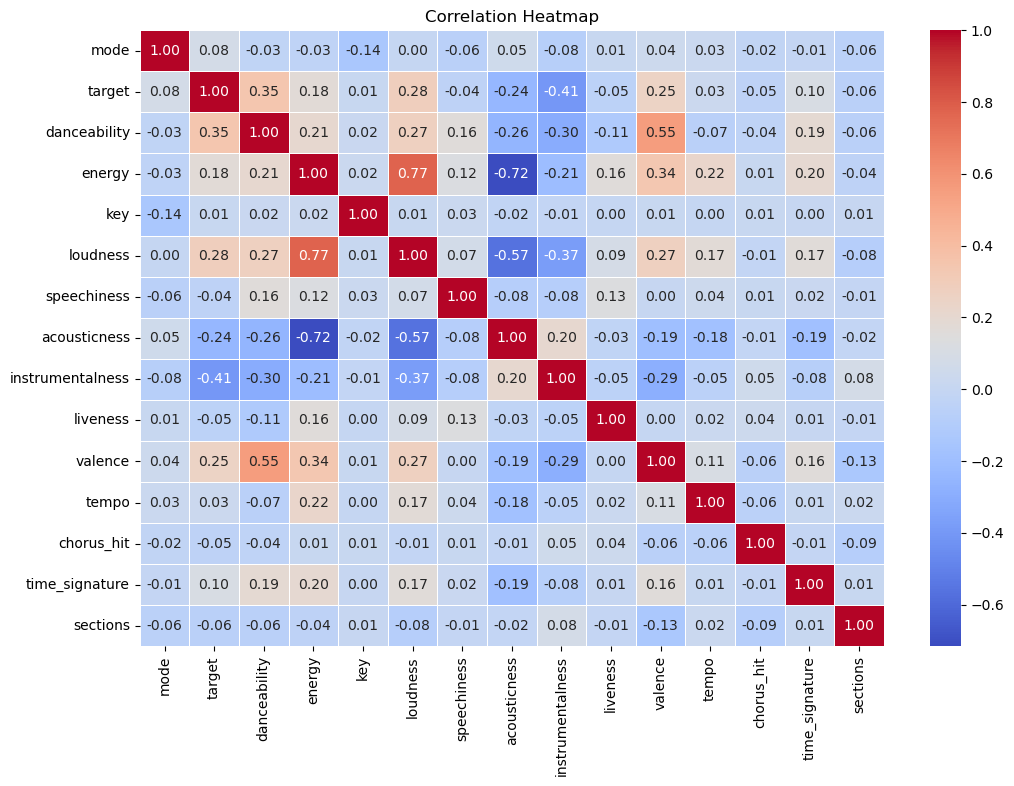

Attributes Correlated with Popularity:
instrumentalness    0.405966
danceability        0.345795
loudness            0.284459
valence             0.251096
acousticness        0.243635
energy              0.175415
time_signature      0.104396
sections            0.061392
liveness            0.051021
chorus_hit          0.045443
speechiness         0.040329
tempo               0.032414
key                 0.009977
Name: target, dtype: float64

Attributes Correlated with Mode:
key                 0.140217
instrumentalness    0.075968
speechiness         0.059416
sections            0.056906
acousticness        0.049986
valence             0.036558
energy              0.033638
danceability        0.031700
tempo               0.027074
chorus_hit          0.022385
time_signature      0.008982
liveness            0.008512
loudness            0.000487
Name: mode, dtype: float64


In [22]:
# Assuming df is your DataFrame with relevant attributes including 'mode' and 'target' columns

# Select relevant columns for correlation analysis
selected_columns = ['mode', 'target', 'danceability', 'energy', 'key', 'loudness', 'speechiness',
                   'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'chorus_hit',
                   'time_signature', 'sections']

# Create a subset DataFrame with selected columns
subset_df = df[selected_columns]

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Plot the heatmap for correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Extract correlation values for 'target' (popularity) and 'mode'
popularity_correlation = correlation_matrix['target'].drop(['target', 'mode']).abs()
mode_correlation = correlation_matrix['mode'].drop(['target', 'mode']).abs()

# Sort attributes based on correlation with popularity and mode
popularity_correlation_sorted = popularity_correlation.sort_values(ascending=False)
mode_correlation_sorted = mode_correlation.sort_values(ascending=False)

# Display the sorted attributes and their correlation values
print("Attributes Correlated with Popularity:")
print(popularity_correlation_sorted)

print("\nAttributes Correlated with Mode:")
print(mode_correlation_sorted)
